# Toy Environment

This is a toy environment based on the Node and Tree structure used for branch and bound, used to diagnose issues with our model structure. 

In [232]:
import numpy as np
import random 

class Node:
    def __init__(self, var_size, node_key):
        """
        Initialize a Node

        Parameters
        ----------
        var_size: Int
            Number of variables to select from in support
        
        node_key: Str
            Name associated with Node, used for Node Lookup

        """
        # Initialize z with all zeros
        self.z = [0] * var_size

        # Set one random variable to a value between 1 and 5
        random_index = random.randint(0, var_size - 1)
        self.z[random_index] = random.randint(1, 5)

        # Each node will store it's children's nodes and current state
        self.node_key = node_key
        self.parent_key = None
        self.is_leaf = True
        self.left = None
        self.right = None
        self.state = None
    
    def assign_children(self, left_child=None, right_child=None):
        '''
        Function assigns children nodes to parent and 
        parent is set to no longer leaf

        inputs:
            left_child: Node associated with Left Child
            right_child: Node associated with Right Child
        '''
        if left_child is not None:
            self.left = left_child
            self.left.parent_key = self.node_key
            self.is_leaf = False
        
        if right_child is not None:
            self.right = right_child
            self.right.parent_key = self.node_key
            self.is_leaf = False

class Tree():
    """
    A class designed for a simple tree exploratory game. 

    Attributes:
        var_size: Number of variables to split on at each node
        goal: Target z to get to finish tree
    """
    def __init__(self, var_size=10, goal=50):
        self.j = var_size
        self.score = 0
        self.goal = goal

        # Algorithm variables - also reset with set_root below
        self.active_nodes = dict()      # Current Nodes
        self.all_nodes = dict()         # All Nodes
        self.node_counter = 0           # Number branch steps taken
        self.root = None

    def start_root(self):
        # Initializes the nodes with a root node
        self.node_counter += 1

        # Initialize root node
        root_node = Node(var_size=self.j, node_key='root_node')
        self.active_nodes['root_node'] = root_node
        self.all_nodes['root_node'] = root_node

        # Start Tree
        self.root = self.active_nodes['root_node']

        return False
    
    def get_state(self, node_key, j):
        '''
        Returns numpy array of 2 values containing problem and variable static states
        as well as tree, node, and variable current states.
        '''
        node = self.all_nodes[node_key]

        state = np.concatenate([[node.z[j]],
                                [len(self.active_nodes)],
                                [self.score],
                                [self.goal],
                                [self.j]])
        return(state)

    def max_frac_branch(self):
        # Finds node with greatest z
        best_node_key = None
        best_z = 0
        best_index = None
        for node_key in self.active_nodes:
            node = self.active_nodes[node_key]
            max_z = max(node.z)
            potential_j = np.argmax(node.z)
            if max_z > best_z:
                best_z = max_z
                best_node_key = node_key
                best_index = potential_j
        return(best_node_key, best_index)
    

    def step(self, branch_node_key, j):
        # Add State to Node in Tree
        branch_node = self.active_nodes[branch_node_key]
        branch_node.state = self.get_state(branch_node_key, j)

        # Create two child nodes
        branch_node = self.active_nodes[branch_node_key]
        
        # Branch to beta_j to be 0
        node_name_1 = f'node_{self.node_counter}'
        self.active_nodes[node_name_1] = Node(var_size=self.j, node_key=node_name_1)
        self.node_counter += 1

        # Branch to beta_j to be 1
        node_name_2 = f'node_{self.node_counter}'
        self.active_nodes[node_name_2] = Node(var_size=self.j, node_key=node_name_2)
        self.node_counter += 1

        # Store New Nodes in all_nodes Dictionary
        self.all_nodes[node_name_1] = self.active_nodes[node_name_1]
        self.all_nodes[node_name_2] = self.active_nodes[node_name_2]

        # Store Child Nodes in Tree
        branch_node.assign_children(self.active_nodes[node_name_1], \
                                   self.active_nodes[node_name_2])
        del self.active_nodes[branch_node_key] # Delete Parent from Active Nodes

        # Check for End
        points = branch_node.state[0]

        self.score += points
        if self.score >= self.goal:
            return True

        return False
    
    def drop_leaves(self, node):
        if not node:
            return None

        if node.is_leaf:
            # If it's a leaf, return None to remove it
            return None

        # Recursively drop leaves in left and right subtrees
        node.left = self.drop_leaves(node.left)
        node.right = self.drop_leaves(node.right)

        # If both children are None, this node becomes a leaf
        if node.left is None and node.right is None:
            node.is_leaf = True

        return node
    
    def get_state_pairs(self, node):
        '''
        Recursively collect tree edges, parent and child states pairs

        input:
            node: node of tree
        return:
            list of (previous state, state, reward) tuples
        '''
        pairs = []

        if not node:
            return pairs

        # Check left child
        if node.left:
            if node.left.is_leaf:
                pairs.append((node.state, node.left.state, 0))
            else:
                pairs.append((node.state, node.left.state, -1))
            pairs.extend(self.get_state_pairs(node.left))

        # Check right child
        if node.right:
            if node.right.is_leaf:
                pairs.append((node.state, node.right.state, 0))
            else:
                pairs.append((node.state, node.right.state, -1))
            pairs.extend(self.get_state_pairs(node.right))

        return pairs


    def play(self):
        self.start_root()

        fin_solving = False
        iters = 0

        while (not fin_solving) and (iters < 100):
            # Find optimal node_key and j
            node_key, j = self.max_frac_branch()

            # Take Step
            fin_solving = self.step(node_key, j)

            iters += 1

        return(iters)

In [233]:
import random
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque, namedtuple

# Settings
MAX_ITERS = 100 
EPSILON_START = 1
EPSILON_END = 0.05 
EPSILON_DECAY = 0.999
BATCH_SIZE = 32 
GAMMA = 0.99
TARGET_UPDATE = 10


# Memory representation of states
Transition = namedtuple('Transition', 
                        ('prev_state', 'state', 'reward'))

# Deep Q Network
class DQN(nn.Module):
    def __init__(self, input_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        output1 = F.leaky_relu(self.fc1(x))
        output2 = F.leaky_relu(self.fc2(output1))
        output = self.fc3(output2)               # Excluding relu from last layer
        return(output)

# Memory for our agent
class Memory(object):
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Agent that performs, remembers and learns actions
class Agent():
    def __init__(self):
        self.policy_net = DQN(5)
        self.target_net = DQN(5)
        self.optimizer = optim.RMSprop(self.policy_net.parameters())
        self.memory = Memory(10000)
        self.episodes_played = 0
        self.epsilon = EPSILON_START
        self.epsilon_decay = EPSILON_DECAY
        self.epsilon_end = EPSILON_END

    def retrobranch(self, tree:Tree):
        """
        Complete all leaf states in finished tree, then store all state pairs in memory
        Uses max_frac_branch for completing tree for efficiency
        Checks if episodes_played divisible by TARGET_UPDATE, if so updates target network

        Parameters
        ----------
        tree: Tree Class
            the finished tree for retrobranching
        
        total_reward: Int
            total reward for playing through tree
        """

        # Drop current leaves (unvisited node)
        tree.drop_leaves(tree.root)

        # Set rewards
        total_reward = 0

        # Call tree function to create all state to state pairs
        state_pairs = tree.get_state_pairs(tree.root)

        for prev, curr, r in state_pairs:
            total_reward += r

            # Add state pairs and reward to memory 
            self.memory.push(torch.tensor(np.array([prev]), dtype=torch.float), 
                            torch.tensor(np.array([curr]), dtype=torch.float), 
                            torch.tensor([r], dtype=torch.float))
        
        # Update target network
        if self.episodes_played % TARGET_UPDATE == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

        return total_reward

    def select_action(self, T:Tree):
        """
        Select an optimal node and j to split on given a tree

        Parameters
        ----------
        T: Tree Class
            the tree to select an action on
        
        best_node_key: Str
            string tied to the node to split on
        best_j: Int
            int representing the variable to split on
        """

        # Select an action according to an epsilon greedy approach        
        if (random.random() < self.epsilon):
            # max fraction branching
            best_node_key, best_j = T.max_frac_branch()
        else:
            # calculate estimated value for all nodes
            best_val = -math.inf
            best_node_key = None
            best_j = 0

            for node_key in T.active_nodes:
                for i in range(T.j):
                    state = torch.tensor(np.array([T.get_state(node_key, i)]), dtype=torch.float)
                    val = self.policy_net(state) 
                    if(val > best_val):
                        best_val = val
                        best_node_key = node_key
                        best_j = i

        return(best_node_key, best_j)
    
    def replay_memory(self):
        """
        Samples a BATCH_SIZE number of items from memory, optimizes and updates policy network
        """

        # Only Replay Memory if enough enteries in Memory
        if len(self.memory) < BATCH_SIZE:
            return
        
        # Sample from our memory
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        # Concatenate our tensors for previous states
        prev_state_batch = torch.cat(batch.prev_state)
        state_batch = torch.cat(batch.state)
        reward_batch = torch.cat(batch.reward)

        # Predict Q-values for the previous states
        pred_q_values = self.policy_net(prev_state_batch)
        pred_q_values = pred_q_values.squeeze(1) # Match shape of targets

        # Compute expected Q-values based on next states and rewards
        with torch.no_grad():
            max_next_q_values = torch.flatten(self.target_net(state_batch))
            targets = reward_batch + GAMMA * max_next_q_values

        # Compute loss
        loss_f = nn.MSELoss()
        loss = loss_f(pred_q_values, targets)

        # Optimization
        self.optimizer.zero_grad()
        loss.backward()

        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)

        if self.epsilon > self.epsilon_end:
            self.epsilon *= self.epsilon_decay
        
        # Update Parameters
        self.optimizer.step()


    def RL_solve(self, var_size=10, goal=50):
        # Initialize Tree
        T = Tree(var_size=var_size, goal=goal)

        # Solving an instance using agent to make choices in tree
        fin_solving = T.start_root()
        iters = 0

        while (fin_solving == False) and (iters < MAX_ITERS):
            # Select and perform an action
            node, j = self.select_action(T)
            fin_solving = T.step(node, j) 
            iters += 1

        # Store tree in memory and get total reward for tree
        tot_reward = self.retrobranch(T)

        # Optimize the target network using replay memory 
        # 16 iters after each episode
        for i in range(16):
            self.replay_memory()

        # Update number of episodes Agent has played
        self.episodes_played += 1
            
        return(iters)

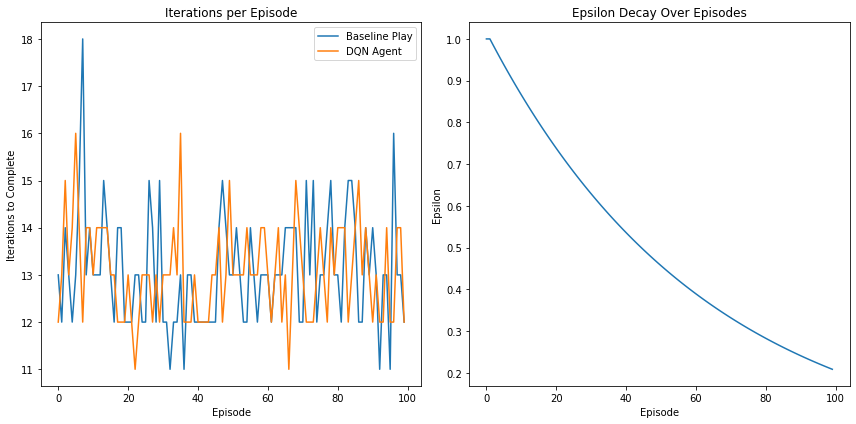

In [239]:
import matplotlib.pyplot as plt

# Initialize the agent
agent = Agent()

# Lists to store results
max_iters = []
rl_iters = []
epsilons = []

# Play through 100 episodes using both methods
for episode in range(100):
    # Reset the tree for a new game
    tree = Tree(10, 50)

    # Play using the baseline method
    iters = tree.play()
    max_iters.append(iters)

    # Play using the RL agent
    iters = agent.RL_solve(10, 50)
    rl_iters.append(iters)
    epsilons.append(agent.epsilon)

# Plotting the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(max_iters, label='Baseline Play')
plt.plot(rl_iters, label='DQN Agent')
plt.xlabel('Episode')
plt.ylabel('Iterations to Complete')
plt.title('Iterations per Episode')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay Over Episodes')

plt.tight_layout()
plt.show()

In [272]:
# State: Points at node/j, number of active nodes, current score, goal score, number of variables / paths 
agent.policy_net(torch.tensor([[5.0, 1.0, 0.0, 50.0, 10]]))

tensor([[-2.6376]], grad_fn=<AddmmBackward0>)

In [274]:
agent.policy_net(torch.tensor([[5.0, 1.0, 0.0, 50.0, 10]])) - agent.policy_net(torch.tensor([[0.0, 1.0, 0.0, 50.0, 10]]))

tensor([[0.5910]], grad_fn=<SubBackward0>)

In [273]:
agent.RL_solve(5,100)

25

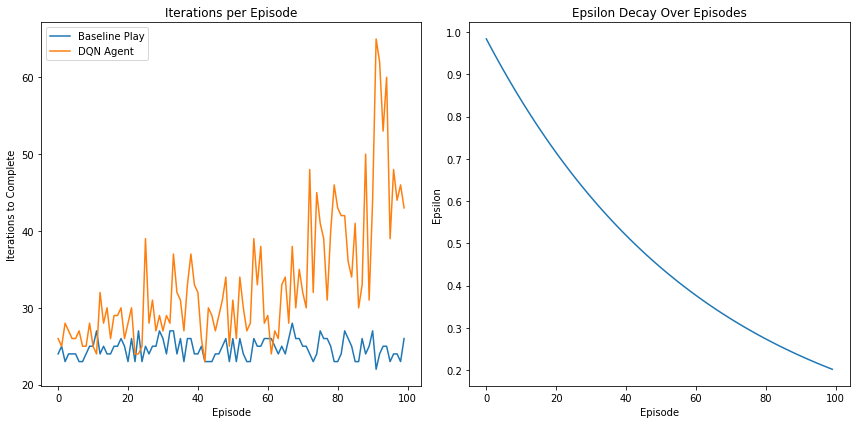

In [197]:
import matplotlib.pyplot as plt

# Initialize the agent
agent = Agent()

# Lists to store results
max_iters = []
rl_iters = []
epsilons = []

# Play through 100 episodes using both methods
for episode in range(100):
    # Reset the tree for a new game
    tree = Tree(10, 100)

    # Play using the baseline method
    iters = tree.play()
    max_iters.append(iters)

    # Play using the RL agent
    iters = agent.RL_solve(10, 100)
    rl_iters.append(iters)
    epsilons.append(agent.epsilon)

# Plotting the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(max_iters, label='Baseline Play')
plt.plot(rl_iters, label='DQN Agent')
plt.xlabel('Episode')
plt.ylabel('Iterations to Complete')
plt.title('Iterations per Episode')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay Over Episodes')

plt.tight_layout()
plt.show()

In [198]:
# State: Points at node/j, number of active nodes, current score, goal score, number of variables / paths 
agent.policy_net(torch.tensor([[0.0, 1.0, 0.0, 50.0, 10]]))

tensor([[-1.0734]], grad_fn=<AddmmBackward0>)

In [199]:
agent.policy_net(torch.tensor([[5.0, 1.0, 0.0, 50.0, 10]])) - agent.policy_net(torch.tensor([[0.0, 1.0, 0.0, 50.0, 10]]))

tensor([[0.1349]], grad_fn=<SubBackward0>)

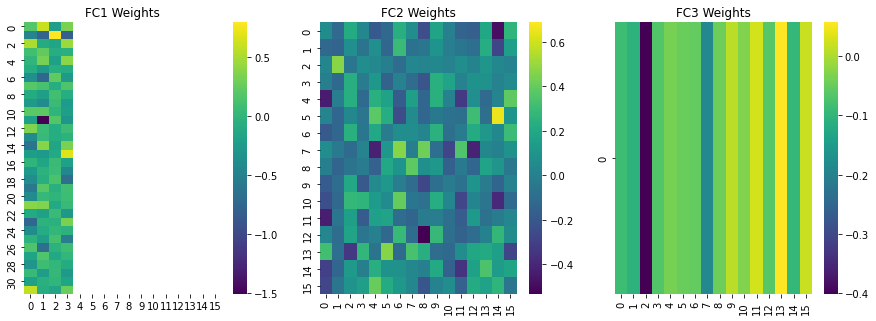

In [133]:
weights_fc1 = agent.policy_net.fc1.weight.data.numpy()
weights_fc2 = agent.policy_net.fc2.weight.data.numpy()
weights_fc3 = agent.policy_net.fc3.weight.data.numpy()

import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

# Draw a heatmap with the weights
sns.heatmap(weights_fc1, ax=axes[0], cmap="viridis")
axes[0].set_title('FC1 Weights')

sns.heatmap(weights_fc2, ax=axes[1], cmap="viridis")
axes[1].set_title('FC2 Weights')

sns.heatmap(weights_fc3, ax=axes[2], cmap="viridis")
axes[2].set_title('FC3 Weights')

plt.show()
